In [1]:
%%capture
%pip install --upgrade numpy
%pip install --upgrade scipy

In [2]:
from platform import python_version
print(python_version())

3.7.13


In [3]:
# Обновиться до версии 1.8.1 не получиться, так как Google Colab работает на Python 3.7, а нужно 3.8
import scipy
print(scipy.__version__)

1.7.3


In [4]:
# Импорт библиотек
import math
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Set
from tqdm.notebook import tqdm

import scipy.stats as stats
from scipy.stats import wilcoxon, mannwhitneyu,f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import norm
# from scipy.stats import permutation_test

import statsmodels.stats.proportion as proportion
import statsmodels.stats.power as power
import statsmodels.stats.api as sms
from statsmodels.stats.weightstats import CompareMeans, DescrStatsW
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt 
import seaborn as sns
import pylab
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Распределение Бернулли. Биномиальное распределение

Производитель утверждает, что не более 10% оборудования имеют дефекты. 15 станков проверены, 3 имели дефекты. Проверьте утверждение производителя.

Нулевая гипотеза не может быть отвергнута на уровне значимости 5%, поскольку возвращаемое значение p больше критического значения 5%.

In [5]:
stats.binom_test(3, n=15, p=0.1, alternative='greater')

0.18406106910639106

Предположим, мы проверяем умеет ли сотрудник магазина овощей и фруктов визуально определять свежий авокадо или нет. Проведем эксперимент 1000 раз. Предположим, что ответ консультанта как результат подбрасывания правильной монеты, то есть вероятность того или иного ответа равна 0.5

In [6]:
# Консультант 550 ответил правильно и 450 нет
result = np.concatenate((np.ones(550), np.zeros(450)))

In [7]:
p_0 = 0.5
mean = result.mean()
z_stat = (mean - p_0)/np.sqrt(p_0 * (1 - p_0)/len(result))
print(z_stat)

3.162277660168382


In [8]:
# Доверительный интервал
# Таким образом, в данном примере продавец решает поставленную задачу с большой вероятностью лучше бросания монетки.
mean - 1.96 * np.sqrt(mean * (1 - mean)/len(result)), mean + 1.96 * np.sqrt(mean * (1 - mean)/len(result))

(0.5191650198637976, 0.5808349801362025)

# Тест, отличается ли среднее выборки от N

In [9]:
# Создаем данные
x1 = [64.2, 28.4, 85.3, 83.1, 13.4, 56.8, 44.2, 90, 86, 75]
y1 = [45, 29.5, 32.3, 49.3, 18.3, 34.2, 43.9, 13.8, 27.4, 43.4]

In [10]:
N=10
stats.ttest_1samp(x1, N)

Ttest_1sampResult(statistic=6.265559754169641, pvalue=0.00014688203506718392)

# Доверительный интервал

### Доверительный интервал для одной выборки

In [11]:
np.mean(x1)

62.64

In [12]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [13]:
print(mean_confidence_interval(x1))
print(mean_confidence_interval(y1))

(62.64, 43.63452280102512, 81.64547719897487)
(33.709999999999994, 25.239440514271045, 42.18055948572894)


In [14]:
def mean_confidence_interval_(data, confidence=0.95):
    return stats.t.interval(confidence, len(data)-1, loc=np.mean(data), scale=stats.sem(data))

In [15]:
print(mean_confidence_interval_(x1))
print(mean_confidence_interval_(y1))

(43.63452280102512, 81.64547719897487)
(25.239440514271045, 42.18055948572894)


### Доверительный интервал разности средних для двух независимых выборок

In [16]:
def mean_diff_confint_ind(sample1,sample2):
    cm = CompareMeans(DescrStatsW(sample1), DescrStatsW(sample2))
    return cm.tconfint_diff(alternative='two-sided',usevar='pooled')

In [17]:
# Построим 95% доверительный интервал для разности средних. Данный интервал не содержит ноль - значит разницу можно признать отличной от нуля.
mean_diff_confint_ind(x1,y1)

(9.605408640774549, 48.254591359225465)

# Z оценка

In [18]:
list_number = [7,8,8,9,10]
# Рассчитываем среднее
mean = np.mean(list_number)
print(mean)
# Рассчитываем дисперсию
var = np.var(list_number,ddof=1)
print(var)
# Рассчитываем стандартное отклонение
std = round(np.std(list_number,ddof=1),2)
print(std)
# Рассчитаем z-оценку для 7.5
z = (7.5-mean)/std
print(z)

8.4
1.2999999999999998
1.14
-0.7894736842105267


# Z тест

In [19]:
z,z_pval = ztest(x1, y1, value=0,alternative='two-sided')
print(z,z_pval)

3.145198441422933 0.001659742067075731


In [20]:
def z_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    if not isinstance(test, pd.Series):
      test = pd.Series(test)
    if not isinstance(control, pd.Series):
      control = pd.Series(control)

    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = 1 - (stats.norm.cdf(z) - stats.norm.cdf(-z))
    
    def critial(se,n): return se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1, len(test))}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2, len(control))}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff,len(test)+len(control))}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")

In [21]:
z_test(x1,y1)

Test 95.0% CI: 62.64 +- 19.00547719897488
Control 95.0% CI: 33.709999999999994 +- 8.470559485728947
Test-Control 95.0% CI: 28.930000000000007 +- 19.251944518526734
Z Statistic 3.145198441422933
P-Value 0.0016597420670756424


# t-тест двух независимых выборок

### Проверка на нормальность данных. Тест Шапиро-Уилка

In [22]:
# Тест Шапиро-Уилка
stat, p = stats.shapiro(x1)
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.894, p-value=0.189
Принять гипотезу о нормальности


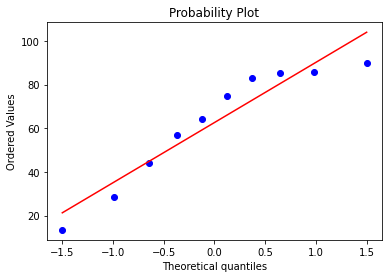

In [23]:
# Графический метод
stats.probplot(x1, dist="norm", plot=pylab)
pylab.show()

### Проверка равенства дисперсий. Критерий Бартлетта

Цитата из Википедии: "Критерий Бартлетта (англ. Bartlett's test) — статистический критерий, позволяющий проверять равенство дисперсий нескольких (двух и более) выборок. Нулевая гипотеза предполагает, что рассматриваемые выборки получены из генеральных совокупностей, обладающих одинаковыми дисперсиями.

Критерий Бартлетта является параметрическим и основан на дополнительном предположении о нормальности выборок данных. Поэтому перед применением критерия Бартлетта рекомендуется выполнить проверку нормальности. Критерий Бартлетта очень чувствителен к нарушению данного предположения.

Плюсы:

объёмы выборок могут быть различными (это его преимущество перед критерием Кохрена), критерий Бартлетта выявляет отклонения, как в наибольшую, так и в наименьшую стороны; Минусы:

сложность вычислений (критерий Кохрена требует меньше вычислительных затрат. Особо это актуально в случае вычислений «вручную»), объём каждой выборки должен быть больше трёх, критерий очень чувствителен к нарушению предположения о нормальности закона распределения исходных данных."

In [24]:
x1_ = np.random.normal(0, 1.5, 100)
x2_ = np.random.normal(0, 1.5, 100)

In [25]:
# Расчет дисперсий
var1 = np.var(x1_)
var2 = np.var(x2_)
print(var1, var2)

2.282626216799826 2.6016052181840537


In [26]:
# Критерий Бартлетта
stat, p = stats.bartlett(x1_,x2_)
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о равенстве дисперсий')
else:
    print('Отклонить гипотезу о равенстве дисперсий')

Statistics=0.421, p-value=0.516
Принять гипотезу о равенстве дисперсий


###  Проверка гипотезы. t-критерий Стьюдента

t-критерий Стьюдента – общее название для класса методов статистической проверки гипотез (статистических критериев), основанных на распределении Стьюдента. Наиболее частые случаи применения t-критерия связаны с проверкой равенства средних значений в двух выборках.
Для применения t-критерия Стьюдента необходимо, чтобы исходные данные имели нормальное распределение. Также имеет значение равенство дисперсий (распределения) сравниваемых групп (гомоскедастичность). При неравных дисперсиях применяется t-критерий в модификации Уэлча (Welch's t).

t-критерий «боится» выбросов, т.е. аномальных отклонений. Выбросы в данных сильно искажают распределение t-критерия, что, в свою очередь, может привести к ошибкам статистического вывода, поэтому от аномальных наблюдений следует избавиться. Часто из выборки удаляют все значения, выходящие за пределы ±2 стандартных отклонения от средней.

При отсутствии нормального распределения сравниваемых выборок вместо t-критерия Стьюдента используются аналогичные методы непараметрической статистики, среди которых наиболее известными является U-критерий Манна — Уитни.

In [27]:
# H0 - между выборками нет статистически значимых различий
# H1 - между выборками есть статистически значимые различия
stats.ttest_ind(x1, y1,alternative='two-sided')

Ttest_indResult(statistic=3.145198441422933, pvalue=0.005596956346997708)

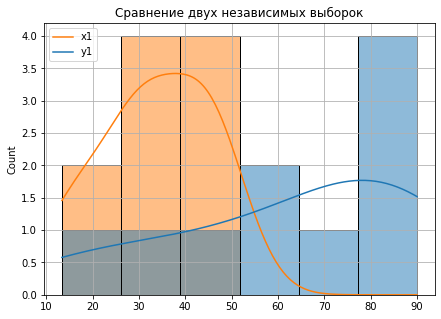

In [28]:
plt.figure(figsize=(7, 5))
df1 = pd.DataFrame({'x1':x1,'y2':y1})
sns.histplot(data=df1, kde=True)
plt.title('Сравнение двух независимых выборок')
plt.legend(['x1', 'y1'])
plt.grid()

# t-тест двух зависимых выборок

In [29]:
# Создаем данные
x2 = np.random.normal(0, 1.5, 100)
y2 = np.random.normal(1, 1.5, 100)

### Проверка на нормальность данных

In [30]:
# Критерий Пирсона
stat, p = stats.normaltest(x2)
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.378, p-value=0.828
Принять гипотезу о нормальности


### Проверка гипотезы

In [31]:
# H0 - между выборками нет статистически значимых различий
# H1 - между выборками есть статистически значимые различия
stats.ttest_rel(x2, y2,alternative='two-sided')

Ttest_relResult(statistic=-5.812108139318027, pvalue=7.537465195773137e-08)

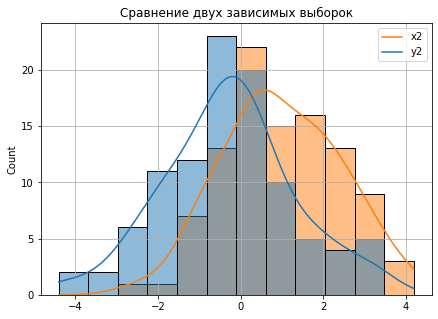

In [32]:
plt.figure(figsize=(7, 5))
df2 = pd.DataFrame({'x2':x2,'y2':y2})
sns.histplot(data=df2, kde=True)
plt.title('Сравнение двух зависимых выборок')
plt.legend(['x2', 'y2'])
plt.grid()

# t-критерий Уэлча

t-критерий Уэлча — тест, основанный на распределении Стьюдента и предназначенный для проверки статистической гипотезы о равенстве математических ожиданий случайных величин, имеющих необязательно равные известные дисперсии. Является модификацией t-критерия Стьюдента. Назван в честь британского статистика Бернарда Льюиса Уэлча.

In [33]:
#equal_var:  указывает на предположение об одинаковой дисперсии между двумя массивами
stats.ttest_ind(x1, y1,equal_var=False)

Ttest_indResult(statistic=3.145198441422933, pvalue=0.008121457311362348)

# Непараметрические критерии

### U-критерий Манна — Уитни

In [34]:
#  Статистический критерий, используемый для оценки различий между двумя независимыми выборками по уровню какого-либо признака, 
# измеренного количественно. Позволяет выявлять различия в значении параметра между малыми выборками.

In [35]:
np.random.seed(11)
A = stats.norm.rvs(scale=30,loc=11,size=100)
B = A + stats.norm.rvs(scale=54,loc=11,size=100)

In [36]:
# H0 - различий нет
# H1 - различия есть
stat, p = mannwhitneyu(A, B,alternative='two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Различий в эффекте нет')
else:
    print('Различия в эффекте есть')

Statistics=4343.000, p=0.109
Различий в эффекте нет


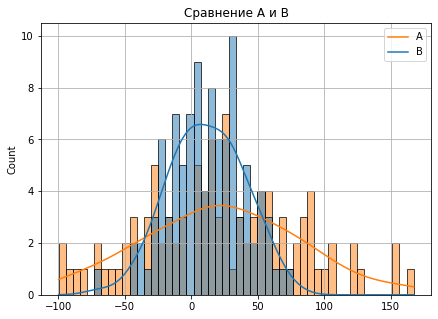

In [37]:
plt.figure(figsize=(7, 5))
df = pd.DataFrame({'A':A, 'B':B})
sns.histplot(data=df, kde=True, bins=50)
plt.title('Сравнение A и B')
plt.legend(['A', 'B'])
plt.grid()

### Т-критерий Вилкоксона

In [38]:
# Также используются названия Т-критерий Уилкоксона, критерий Вилкоксона, критерий знаковых рангов Уилкоксона, критерий суммы рангов Уилкоксона.
# Непараметрический статистический тест (критерий), используемый для проверки различий между двумя выборками парных или независимых измерений по уровню
# какого-либо количественного признака, измеренного в непрерывной или в порядковой шкале. Впервые предложен Фрэнком Уилкоксоном. 
# Другие названия — W-критерий Вилкоксона, критерий знаковых рангов Вилкоксона, критерий Уилкоксона для связных выборок. 
# Тест Вилкоксона для независимых выборок также называется критерием Манна-Уитни.

In [39]:
np.random.seed(11)
C = stats.norm.rvs(scale=30,loc=11,size=100)
D = C + stats.norm.rvs(scale=54,loc=11,size=100)

In [40]:
# H0 - различий нет
# H1 - различия есть
stat, p = wilcoxon(C,D,alternative='two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Различий в эффекте нет')
else:
    print('Различия в эффекте есть')

Statistics=1930.000, p=0.041
Различия в эффекте есть


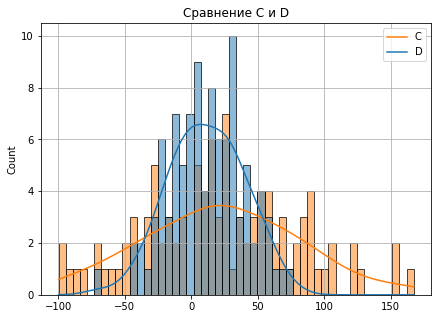

In [41]:
plt.figure(figsize=(7, 5))
df = pd.DataFrame({'C':C, 'D':D})
sns.histplot(data=df, kde=True, bins=50)
plt.title('Сравнение C и D')
plt.legend(['C', 'D'])
plt.grid()

###  Бутстреп. Вариант 1

In [42]:
# Генерация данных для примера
mu_group1, sigma_group1 = 10, 0.5
group1 = np.random.normal(mu_group1, sigma_group1, 1000)

In [43]:
abs(mu_group1 - np.mean(group1))

0.0038026324918032373

In [44]:
abs(sigma_group1 - np.std(group1, ddof=1))

0.006552551245068594

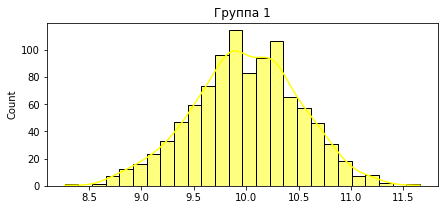

In [45]:
plt.figure(figsize=(7, 3))
sns.histplot(group1, kde=True, color='yellow')
plt.title('Группа 1')
plt.show()

In [46]:
mu_group2, sigma_group2 = 11, 1.5
group2 = np.random.normal(mu_group2, sigma_group2, 1000)

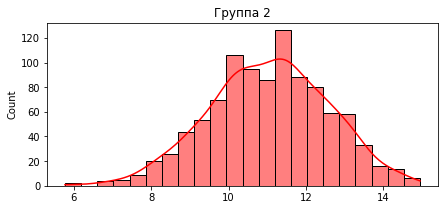

In [47]:
plt.figure(figsize=(7, 3))
sns.histplot(group2, kde=True, color='red')
plt.title('Группа 2')
plt.show()

In [48]:
def get_bootstrap_samples(data, n_samples):
    """Бутстрап-выборка"""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [49]:
def stat_intervals(stat, alpha=0.05):
    """Доверительный интервал"""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [50]:
group1_median = list(map(np.median, get_bootstrap_samples(group1, 1000)))
group2_median  = list(map(np.median, get_bootstrap_samples(group2, 1000)))

In [51]:
delta_median = list(map(lambda x: x[1] - x[0], zip(group1_median, group2_median)))

In [52]:
print ("Макc значение для для группы1:", np.max(group1),"Мин значение для для группы1:", np.min(group1))
print ("Макc значение для для группы2:", np.max(group2),"Мин значение для для группы2:", np.min(group2))
print ("95% доверительный интервал для группы1:", stat_intervals(group1_median, 0.05))
print ("95% доверительный интервал для группы2:",  stat_intervals(group2_median, 0.05))
print ("95% доверительный интервал для разности медиан:",  stat_intervals(delta_median, 0.05))

Макc значение для для группы1: 11.657341175782976 Мин значение для для группы1: 8.269858613810245
Макc значение для для группы2: 14.950993207906738 Мин значение для для группы2: 5.769085624116061
95% доверительный интервал для группы1: [ 9.94826854 10.03933557]
95% доверительный интервал для группы2: [10.92730778 11.22665461]
95% доверительный интервал для разности медиан: [0.92622794 1.24254135]


### Бутстреп. Вариант 2 (karpov_courses)

In [53]:
def get_bootstrap(
                  data_column_1,                       
                  data_column_2,                       
                  boot_it = 1000,                      
                  statistic = np.mean,                 
                  bootstrap_conf_level = 0.95          
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):      
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True              
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [54]:
df_bootstrap = pd.DataFrame(data={'group1':group1, 'group2':group2})

  0%|          | 0/1000 [00:00<?, ?it/s]

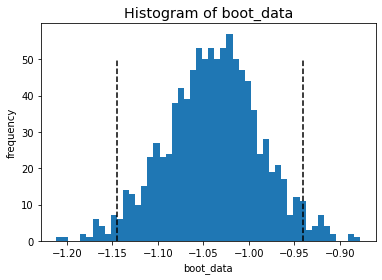

In [55]:
# Бутстрап (np.mean)
# Чувствителен к выбросам данных
booted_data_mean = get_bootstrap(df_bootstrap['group1'], df_bootstrap['group2'], statistic = np.mean)

In [56]:
# p-value (с np.mean), p-value
booted_data_mean['p_value']

6.655397549370097e-90

  0%|          | 0/1000 [00:00<?, ?it/s]

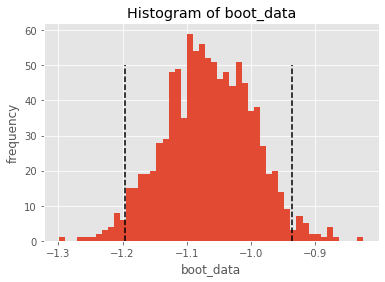

In [57]:
# Бутстрап (с np.median)
# Менее чувствителен к выбросам данных
booted_data_median = get_bootstrap(df_bootstrap['group1'], df_bootstrap['group2'], statistic = np.median)

In [58]:
# p-value (с np.median), 
booted_data_median['p_value']

2.559413723333186e-55

### Перестановочный тест

In [59]:
data1 = np.random.normal(0, 10, size=100)
data2 = np.random.normal(0, 1, size=100)

In [60]:
def permutation_test(data_fst, data_snd, iters=1000, plot=True):
    data = np.array(list(data_fst) + list(data_snd))
    size = len(data)
    values = []
    fst_ratio = len(data_fst) * 1. / size
    for _ in range(iters):
        mask = (np.random.random(size=size) < fst_ratio)
        values.append(data[mask].mean() - data[~mask].mean())
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return (np.abs(values) > np.abs(data_fst.mean() - data_snd.mean())).mean()

In [61]:
print(stats.ttest_ind(data1, data2, alternative='two-sided').pvalue)

0.926805414945115


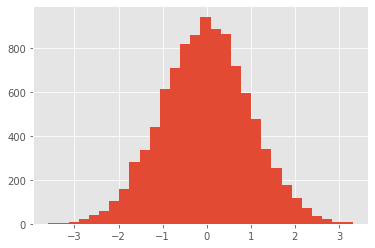

0.9221


In [62]:
print(permutation_test(data1, data2, iters=10000))

# Корреляция

### Коэффициент корреляции Пирсона

In [63]:
data = {'x1':[2,3,4,15,18],
        'x2':[0,-21,0,-30,12],
        'x3':[2,3,4,5,6],
        'y1':[0.2,0.3,0.4,0.5,0.6],
        'y2':[11.0,-30.2,12.0,-42.5,43.0]}

In [64]:
df = pd.DataFrame(data)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      5 non-null      int64  
 1   x2      5 non-null      int64  
 2   x3      5 non-null      int64  
 3   y1      5 non-null      float64
 4   y2      5 non-null      float64
dtypes: float64(2), int64(3)
memory usage: 328.0 bytes


,x1,x2,x3,y1,y2
0,2,0,2,0.2,11.0
1,3,-21,3,0.3,-30.2
2,4,0,4,0.4,12.0
3,15,-30,5,0.5,-42.5
4,18,12,6,0.6,43.0


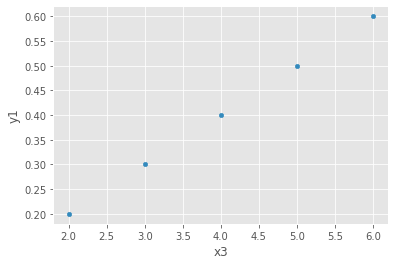

In [65]:
df.plot(kind='scatter', x='x3', y='y1')

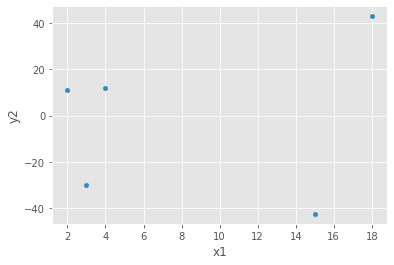

In [66]:
df.plot(kind='scatter', x='x1', y='y2')

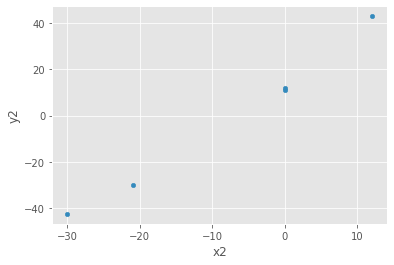

In [67]:
df.plot(kind='scatter', x='x2', y='y2')

In [68]:
# Коэффициент корреляции Пирсона (r-Пирсона) применяется для исследования взаимосвязи двух переменных, измеренных в метрических шкалах на одной и той же выборке. 
# Он позволяет определить, насколько пропорциональная изменчивость двух переменных.
df[['x2', 'y2']].corr()

,x2,y2
x2,1.000000,0.994319
y2,0.994319,1.000000


### Коэффициент ранговой корреляции Спирмена

In [69]:
# Непараметрический метод, который используется с целью статистического изучения связи между явлениями. 
# В этом случае определяется фактическая степень параллелизма между двумя количественными рядами изучаемых признаков и дается оценка тесноты установленной связи с помощью количественно выраженного коэффициента.
df[['x2', 'y2']].corr(method='spearman')

,x2,y2
x2,1.000000,0.974679
y2,0.974679,1.000000


#Дисперсионный анализ

### ANOVA

In [70]:
H = [1, 2, 3, 4, 2, 4, 2, 4, 5, 2, 3, 4, 2, 1, 3, 4, 3, 2, 5, 1]
I= [1, 2, 4, 6, 5, 6, 7, 5, 4, 5, 6, 7, 4, 3, 5, 5, 6, 5, 4, 3, 5]
J = [2, 1, 1, 3, 2, 4, 2, 4, 5, 4, 3, 2, 3, 2, 3, 1, 3, 4, 5, 1, 4]

In [71]:
# H0 - различий нет
# H1 - различия есть
F, p = f_oneway(H, I, J)
print('F=%.3f, p=%.5f' % (F, p))
alpha = 0.05
if p > alpha:
    print('Различий в эффекте нет')
else:
    print('Различия в эффекте есть')

F=12.526, p=0.00003
Различия в эффекте есть


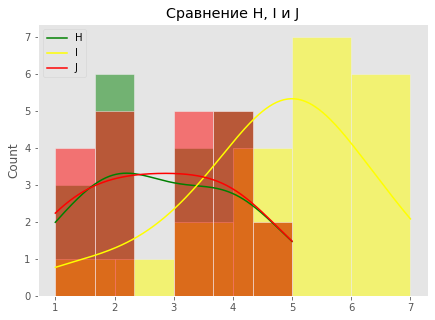

In [72]:
plt.figure(figsize=(7, 5))
sns.histplot(H, kde=True, color='green')
sns.histplot(I, kde=True, color='yellow')
sns.histplot(J, kde=True, color='red')
plt.title('Сравнение H, I и J')
plt.legend(['H', 'I', 'J'])
plt.grid()

# Пропорции

### Тест разности двух независимых долей. Вариант 1

In [73]:
# Реклама "А" получает 3722 откликов на 3830 просмотров, реклама "В" 3872 на 3968
clicks = [3722, 3872] #отклики в каждой группе
views  = [3830, 3968] #просмотры в каждой группе

In [74]:
# Расчет конверсии
p1 = clicks[0]/views[0]
p2 = clicks[1]/views[1]

In [75]:
def confidence_interval(conversion:float, trials:int) -> List[float]:
  '''Функция для нахождения доверительного интервала'''
  sigma = math.sqrt(conversion *(1-conversion )/ trials)
  mu = conversion
  probability = 0.95
  interval = stats.norm.interval(probability, loc=mu, scale=sigma)
  interval_round = [round(_*100, 1) for _ in interval]
  return interval_round

In [76]:
# Расчет z метрики. Вариант 1
p_combined = (clicks[0] + clicks[1]) / (views[0] + views[1])
difference = p1 - p2
z_scores = difference /math.sqrt(p_combined * (1 - p_combined) * (1/views[0] + 1/views[1]))

In [77]:
print(f"Значение z равно {z_scores}")

Значение z равно -1.1076855939322139


In [78]:
# Расчет z метрики. Вариант 2
def proportions_diff_z_stat_ind(clicks1, views1, clicks2, views2, alpha = 0.05):
  p1 = clicks1/views1
  p2 = clicks2/views2
  p = float(p1*views1 + p2*views2) / (views1 + views2)
  return (p1 - p2) / np.sqrt(p * (1 - p) * (1 / views1 + 1 / views2))

In [79]:
print(f"Значение z равно {proportions_diff_z_stat_ind(clicks[0],views[0],clicks[1],views[1])}")

Значение z равно -1.1076855939322139


In [80]:
print(f"Конверсия вариант А равна {round(p1*100,1)}% \
        Доверительный интервал {confidence_interval(p1, views[0])[0]}% - {confidence_interval(p1, views[0])[1]}%")
print(f"Конверсия вариант В равна {round(p2*100,1)}% \
        Доверительный интервал {confidence_interval(p2, views[1])[0]}% - {confidence_interval(p2, views[1])[1]}%")

Конверсия вариант А равна 97.2%         Доверительный интервал 96.7% - 97.7%
Конверсия вариант В равна 97.6%         Доверительный интервал 97.1% - 98.1%


In [81]:
# Рассчитываем p-value. Вариант 1
p_value = (1 - scipy.stats.norm.cdf(abs(z_scores))) * 2
print('p-значение: {:f}'.format(p_value))

p-значение: 0.267998


In [82]:
# Рассчитываем p-value. Вариант 2
def p_value_val(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")   
    if alternative == 'two-sided':
        return 2 * (1 - norm.cdf(np.abs(z_stat)))   
    if alternative == 'less':
        return norm.cdf(z_stat)
    if alternative == 'greater':
        return 1 - norm.cdf(z_stat)

In [83]:
print('p-значение: {:f}'.format(p_value_val(z_scores)))

p-значение: 0.267998


In [84]:
alpha = .05
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Тест разности двух независимых долей. Вариант 2

In [85]:
count = clicks
nobs = views
stat, pval = proportions_ztest(count, nobs, alternative = 'two-sided')
print ("p-value: %f" % pval)

p-value: 0.267998


### Тест Хи-квадрат. Вариант 3

In [86]:
chi2, p, table = proportion.proportions_chisquare(count = count, nobs = nobs)
print ("Хи-квадрат: %f" % chi2)
print ("p-value: %f" % p)

Хи-квадрат: 1.226967
p-value: 0.267998


### Тест Фишера

In [87]:
df3 = pd.DataFrame([[10,15],[39,34]], index=['Рост','Снижение'], columns=['Прогноз','Факт'])
print(df3)

          Прогноз  Факт
Рост           10    15
Снижение       39    34


In [88]:
# H0 - эффект случайный
# H1 - эффект не случайный
oddsratio, pvalue = stats.stats.fisher_exact(df3)
print(pvalue)

0.35417955365927367
